<a href="https://colab.research.google.com/github/heitorabqg/datascientist/blob/master/PSI5892_pca_1208B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# Análise de componentes principais (PCA) e análise de discriminantes lineares (LDA)

Neste exercício, você vai trabalhar com uma aplicação de redes neurais para  para a área de saúde. O objetivo é obter um modelo de predição de uma doença cardíaca baseado em dados com características extraídas de exames clínicos laboratoriais.

## Dados disponibilizados

Os dados para treinamento e teste do modelo estão disponíveis no formato CSV, em um arquivo zip disponível [neste link](./data.zip).

Após extrair os arquivos, utiliza a biblioteca Pandas para carregar os `DataFrames` `data_train` e `data_test`, como mostrado a seguir:

``` python
import pandas as pd

data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])

data_test = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])
```

Os dados consistem de 800 exemplos de treinamento e 225 para teste, cada um contendo 13 características de entrada, representadas pelas colunas de 0 a 12 e a saída desejada binária, indicando se o paciente é portador ou não da doença, representada pela coluna 13.

O objetivo é treinar uma rede neural com estes dados, avaliar o desempenho e depois comparar com o desempenho obtido usando o PCA para realizar redução de dimensionalidade. Use como referência o exemplo mostrado [neste Jupyter Notebook](./PCA_IRIS.ipynb)

# Exercício 1

Implemente uma rede neural para classificar se o indivíduo é portador ou não da doença cardíaca (coluna 13) usando como entrada os dados dos exames laboratoriais (colunas 1 a 12). Calcule a acurácia obtida nos dados de teste.

## Resolução

In [5]:
import torch
import torch.nn as nn
import torch.utils.data as data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carregar dados
data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
data_test  = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])

dados_treino_np = data_train.values
dados_teste_np  = data_test.values


# Normalização dos dados de treino
X_train = dados_treino_np[:, 1:13]
X_test  = dados_teste_np[:, 1:13]

# Média e desvio do treino
mean = X_train.mean(axis=0)
std  = X_train.std(axis=0)

# Evita divisão por zero
std[std == 0] = 1.0

# Normaliza
X_train_norm = (X_train - mean) / std
X_test_norm  = (X_test  - mean) / std

# Recria os arrays completos normalizados (saída permanece a mesma)
dados_treino_norm = dados_treino_np.copy()
dados_treino_norm[:, 1:13] = X_train_norm

dados_teste_norm = dados_teste_np.copy()
dados_teste_norm[:, 1:13] = X_test_norm


# Modelo com ReLU
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(12, 16),
            nn.ReLU(),

            nn.Linear(16, 12),
            nn.ReLU(),

            nn.Linear(12, 8),
            nn.ReLU(),

            nn.Linear(8, 2)  # saída binária
        )

    def forward(self, x):
        return self.model(x)


# Dataloader
def criar_dataloader(dados_np, Nb):
    dados = torch.tensor(dados_np, dtype=torch.float32)

    dataset = [
        (dados[i, 1:13], dados[i, 13].long())
        for i in range(dados.shape[0])
    ]

    loader = data.DataLoader(dataset, batch_size=Nb, shuffle=True)
    return loader


# Treinamento
def treino(model, train_loader, Ne, device):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss()

    losses = []
    model.to(device)

    for epoch in range(Ne):
        for n, (X, d) in enumerate(train_loader):

            X, d = X.to(device), d.to(device)

            model.train()
            model.zero_grad()

            y = model(X)
            loss = loss_function(y, d)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        if epoch % 40 == 0:
            print(f"Época {epoch} - Loss {loss.item():.4f}")

    plt.figure()
    plt.plot(losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Curva de treinamento")
    plt.show()

    return losses


# Teste
def testar(model, dados_np, device):
    dados = torch.tensor(dados_np, dtype=torch.float32)

    X = dados[:, 1:13].to(device)
    y_true = dados[:, 13].long().to(device)

    model.eval()
    with torch.no_grad():
        logits = model(X)
        pred = torch.argmax(logits, dim=1)

    acc = (pred == y_true).float().mean().item()
    print(f"Acurácia no teste = {acc*100:.2f}%")

    return acc


# Execução
device = "cuda" if torch.cuda.is_available() else "cpu"

Nb = 32
Ne = 520

train_loader = criar_dataloader(dados_treino_norm, Nb)
model = Model()

losses = treino(model, train_loader, Ne, device)

testar(model, dados_teste_norm, device)


ValueError: could not broadcast input array from shape (800,13) into shape (800,12)

# Exercício 2

Aplique o PCA nos dados de entrada e obtenha uma matriz de dados transformados representando os 12 componentes principais. Mostre o valor da porcentagem de variância explicada acumulada à medida que você considera um maior número de componentes principais.

## Resolução

In [ ]:
import numpy as np
import pandas as pd

# carregar dados

data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
dados = data_train.iloc[:, 1:13].values    # apenas as 12 features

# N = número de amostras
# D = número de dimensões
N, D = dados.shape


# Normalização
mean = np.mean(dados, axis=0)
std  = np.std(dados, axis=0)
std[std == 0] = 1  # evitar divisão por zero

# dados normalizados
X = (dados - mean) / std


# Matriz de Covariância S
S = (1/N) * (X.T @ X)


# Calculo de autovetores e autovalores
# Su = λu
autovalores, autovetores = np.linalg.eig(S)

# autovalores → variâncias explicadas por cada componente
# autovetores → vetores principais (u_k)


# ordenar autovetores e autovalores

idx = np.argsort(autovalores)[::-1]

autovalores = autovalores[idx]
autovetores = autovetores[:, idx]

# Mtriz U
U = autovetores


# Dados projetados

P = U.T @ X.T
P = P.T


# Variância Explicada

variancia_total = np.sum(autovalores)
variancia_explicada = autovalores / variancia_total

variancia_acumulada = np.cumsum(variancia_explicada)



print("\nAutovetores (variância de cada componente):\n", autovalores)
print("\nProporção da variância explicada:\n", variancia_explicada)
print("\nVariância acumulada:\n", variancia_acumulada)



import matplotlib.pyplot as plt
import numpy as np

# Número de componentes (1 até 12)
num_componentes = np.arange(1, len(variancia_acumulada) + 1)

plt.figure(figsize=(8, 5))
plt.plot(num_componentes, variancia_acumulada * 100, marker='o')
plt.title("Variância Explicada Acumulada pelos Componentes Principais")
plt.xlabel("Número de Componentes Principais")
plt.ylabel("Variância Explicada Acumulada (%)")
plt.grid(True)
plt.xticks(num_componentes)
plt.ylim(0, 105)

plt.show()

# Exercício 3

Implemente uma segunda rede neural para fazer a classificação usando o número de componentes principais necessário para incluir 90% da variância explicada. Calcule a acurácia obtida nos dados de teste.

## Resolução

In [ ]:
"""
k = np.argmax(variancia_acumulada >= 0.90) + 1
print("Número de componentes necessários para 90% de variância =", k)


# Transformar treino e teste para PCA
X_train_pca = ((dados_treino_np[:, 1:13] - mean) / std) @ U[:, :k]
X_test_pca  = ((dados_teste_np[:, 1:13]  - mean) / std) @ U[:, :k]

# Labels
y_train = dados_treino_np[:, 13].astype(int)
y_test  = dados_teste_np[:, 13].astype(int)
"""

class PCA_Model(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(k, 16),
            nn.ReLU(),
            nn.Linear(16, 12),
            nn.ReLU(),
            nn.Linear(12, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        return self.model(x)


def criar_dataloader_pca(X, y, batch=32):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)

    dataset = data.TensorDataset(X_tensor, y_tensor)
    loader = data.DataLoader(dataset, batch_size=batch, shuffle=True)
    return loader

# número de componentes para 90%
k = np.argmax(variancia_acumulada >= 0.90) + 1
print("Número de componentes necessários para 90% da variância =", k)

# preparar dataloaders
train_loader_pca = criar_dataloader_pca(X_train_pca, y_train)
test_X_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
test_y_tensor = torch.tensor(y_test, dtype=torch.long)

# modelo
pca_model = PCA_Model(k).to(device)

# treino
optimizer = torch.optim.Adam(pca_model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

for epoch in range(800):
    for Xb, yb in train_loader_pca:
        Xb, yb = Xb.to(device), yb.to(device)

        pca_model.train()
        optimizer.zero_grad()
        out = pca_model(Xb)
        loss = loss_function(out, yb)
        loss.backward()
        optimizer.step()

    if epoch % 40 == 0:
        print(f"Época {epoch} - Loss = {loss.item():.4f}")

# teste
pca_model.eval()
with torch.no_grad():
    logits = pca_model(test_X_tensor.to(device))
    preds = torch.argmax(logits, dim=1)
    acc_pca = (preds == test_y_tensor.to(device)).float().mean().item()

print(f"\nAcurácia no teste usando PCA com {k} componentes: {acc_pca*100:.2f}%")




# Exercício 4

Repita os exercícios 1, 2 e 3, considerando a transformação dos dados usando o LDA no lugar do PCA. Use como referência o exemplo mostrado [neste Jupyter Notebook](./LDA_IRIS.ipynb)

## Resolução

In [11]:
import torch
import torch.nn as nn
import torch.utils.data as data
import pandas as pd

# =====================================================
# 1. CARREGAR DADOS
# =====================================================

data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
data_test  = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])

train_np = data_train.values
test_np  = data_test.values

# Dados brutos
X_train = train_np[:, 1:13]
y_train = train_np[:, 13].astype(int)

X_test  = test_np[:, 1:13]
y_test  = test_np[:, 13].astype(int)

# =====================================================
# 2. NORMALIZAÇÃO
# =====================================================

mean = X_train.mean(axis=0)
std  = X_train.std(axis=0)
std[std == 0] = 1.0

X_train_norm = (X_train - mean) / std
X_test_norm  = (X_test  - mean) / std

X_train_norm = torch.tensor(X_train_norm, dtype=torch.float32)
X_test_norm  = torch.tensor(X_test_norm,  dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

# =====================================================
# 3. IMPLEMENTAÇÃO DO LDA (PYTORCH)
# =====================================================

X = X_train_norm
d = y_train_t
classes = torch.unique(d)
K = len(classes)
K = 12
print("/nQuantidade de classes = ", K)
N, D = X.shape

# Sw (dentro das classes)
Sw = torch.zeros((D, D), dtype=torch.float32)
means = []

m_global = X.mean(dim=0)

for c in classes:
    Xc = X[d == c]
    mc = Xc.mean(dim=0)
    means.append(mc)

    Sw += (Xc - mc).T @ (Xc - mc)

# Sb (entre classes)
Sb = torch.zeros((D, D), dtype=torch.float32)
for i, c in enumerate(classes):
    Nc = (d == c).sum()
    mc = means[i]
    diff = (mc - m_global).reshape(-1, 1)
    Sb += Nc * (diff @ diff.T)

# Resolver Sw^{-1} Sb
S = torch.linalg.solve(Sw, Sb)

# Autovalores e autovetores
lb, w = torch.linalg.eig(S)
lb = lb.real
w = w.real

# Ordenar
idx = torch.argsort(lb, descending=True)
lb = lb[idx]
w = w[:, idx]

# Número de componentes LDA = K−1 (binário → 1 componente)
K_1 = K - 1
print("/nK_1 = ", K_1)
W_LDA = w[:, :K_1]     # (12 × 1)

print("\nAutovalores LDA:", lb)
print("\nMatriz de projeção W_LDA:", W_LDA.shape)

# =====================================================
# 4. VARIÂNCIA EXPLICADA
# =====================================================

var_exp = lb / lb.sum()
var_acum = torch.cumsum(var_exp, dim=0)

print("\nVariância explicada:", var_exp)
print("Variância acumulada:", var_acum)

# =====================================================
# 5. PROJEÇÃO DOS DADOS
# =====================================================

P_train = X_train_norm @ W_LDA       # (N_train × 1)
P_test  = X_test_norm  @ W_LDA       # (N_test  × 1)

# =====================================================
# 6. DATALOADERS
# =====================================================

def criar_loader(P, y, batch=32):
    X_tensor = P.float()
    y_tensor = y.long()
    dataset = data.TensorDataset(X_tensor, y_tensor)
    return data.DataLoader(dataset, batch_size=batch, shuffle=True)

train_loader = criar_loader(P_train, y_train_t)
test_loader  = criar_loader(P_test,  y_test_t)

# =====================================================
# 7. REDE NEURAL (ENTRADA 1D)
# =====================================================

class Model_LDA(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2)
        )
    def forward(self, x):
        return self.model(x)

# =====================================================
# 8. TREINAMENTO
# =====================================================

device = "cuda" if torch.cuda.is_available() else "cpu"

model_lda = Model_LDA().to(device)
optimizer = torch.optim.Adam(model_lda.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

print("\nTreinando rede com LDA...\n")

for epoch in range(2000):
    for Xb, db in train_loader:
        Xb = Xb.to(device)
        db = db.to(device)

        optimizer.zero_grad()
        y = model_lda(Xb)
        loss = loss_function(y, db)
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0:
        print(f"Época {epoch} - Loss = {loss.item():.4f}")

# =====================================================
# 9. AVALIAÇÃO
# =====================================================

model_lda.eval()
correto = 0
total = 0

with torch.no_grad():
    for Xb, db in test_loader:
        Xb = Xb.to(device)
        y = model_lda(Xb)
        _, pred = torch.max(y, 1)
        correto += (pred.cpu() == db).sum().item()
        total += db.size(0)

acc = correto / total
print(f"\n========================")
print(f"Acurácia FINAL (LDA) = {acc*100:.2f}%")
print(f"========================\n")


/nQuantidade de classes =  12
/nK_1 =  11

Autovalores LDA: tensor([ 1.1872e+00,  4.0593e-08,  4.0593e-08,  3.6397e-08,  5.1088e-09,
         3.4279e-10,  3.4279e-10,  0.0000e+00, -7.7519e-11, -2.4252e-09,
        -3.5583e-08, -3.8400e-08])

Matriz de projeção W_LDA: torch.Size([12, 11])

Variância explicada: tensor([ 1.0000e+00,  3.4193e-08,  3.4193e-08,  3.0658e-08,  4.3033e-09,
         2.8874e-10,  2.8874e-10,  0.0000e+00, -6.5296e-11, -2.0428e-09,
        -2.9972e-08, -3.2346e-08])
Variância acumulada: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000])

Treinando rede com LDA...



RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x11 and 1x8)


TREINANDO SEM LDA...

Época: 0 Loss: 1.1730916500091553 Acurácia: 48.62%
Época: 50 Loss: 0.233573317527771 Acurácia: 90.00%
Época: 100 Loss: 0.2339789867401123 Acurácia: 92.50%
Época: 150 Loss: 0.10934565216302872 Acurácia: 96.12%
Época: 200 Loss: 0.10891779512166977 Acurácia: 96.75%
Época: 250 Loss: 0.07915119081735611 Acurácia: 98.62%
Época: 300 Loss: 0.029703866690397263 Acurácia: 98.50%
Época: 350 Loss: 0.032565146684646606 Acurácia: 98.75%
Época: 400 Loss: 0.030056986957788467 Acurácia: 99.50%
Época: 450 Loss: 0.0008980183629319072 Acurácia: 99.88%
Época: 500 Loss: 1.170779432868585e-05 Acurácia: 99.88%
Época: 550 Loss: 0.0005923116113990545 Acurácia: 99.50%
Época: 600 Loss: 0.0004433409485500306 Acurácia: 99.62%
Época: 650 Loss: 0.0009231528965756297 Acurácia: 100.00%
Época: 700 Loss: 0.018128322437405586 Acurácia: 99.38%
Época: 750 Loss: 0.0002819860237650573 Acurácia: 100.00%
Época: 800 Loss: 0.0007908510742709041 Acurácia: 99.62%
Época: 850 Loss: 0.0405438132584095 Acurácia: 

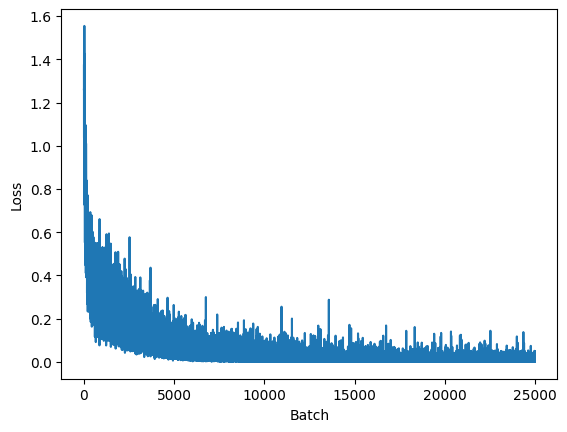

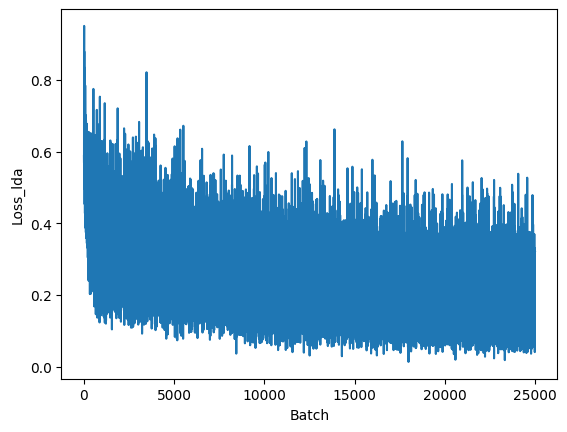

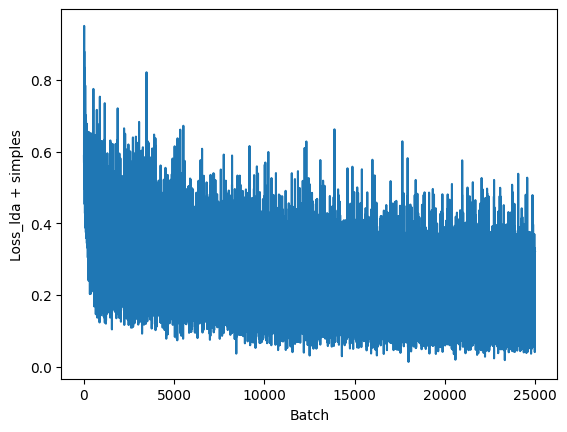

In [30]:
import torch
import torch.nn as nn
import torch.utils.data as data
import pandas as pd


# Ajuste de hiperparâmetros

# passo de adaptação da rede MLP
eta = 0.001

# Tamanho do mini-batch
Nb = 16

# Número de épocas
Ne = 1000

# Carregar dados

data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
data_test  = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])

train_np = data_train.values
test_np  = data_test.values

# Dados brutos
X_train = train_np[:, 1:13]
y_train = train_np[:, 13].astype(int)

X_test  = test_np[:, 1:13]
y_test  = test_np[:, 13].astype(int)


# Normalização
mean = X_train.mean(axis=0)
std  = X_train.std(axis=0)
std[std == 0] = 1.0

X_train_norm = (X_train - mean) / std
X_test_norm  = (X_test  - mean) / std

X_train_norm = torch.tensor(X_train_norm, dtype=torch.float32)
X_test_norm  = torch.tensor(X_test_norm,  dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)



X = X_train_norm
d = y_train_t
classes = torch.unique(d)
K = len(classes)
K = 12
N, D = X.shape

# Sw (dentro das classes)
Sw = torch.zeros((D, D), dtype=torch.float32)
means = []

m_global = X.mean(dim=0)

for c in classes:
    Xc = X[d == c]
    mc = Xc.mean(dim=0)
    means.append(mc)

    Sw += (Xc - mc).T @ (Xc - mc)

# Sb (entre classes)
Sb = torch.zeros((D, D), dtype=torch.float32)
for i, c in enumerate(classes):
    Nc = (d == c).sum()
    mc = means[i]
    diff = (mc - m_global).reshape(-1, 1)
    Sb += Nc * (diff @ diff.T)

# Resolver Sw^{-1} Sb
S = torch.linalg.solve(Sw, Sb)

# Autovalores e autovetores
lb, w = torch.linalg.eig(S)
lb = lb.real
w = w.real

# Ordenar
idx = torch.argsort(lb, descending=True)
lb = lb[idx]
w = w[:, idx]

# Número de componentes LDA = K−1 (binário → 1 componente)
K_1 = K - 1
W_LDA = w[:, :K_1]


# Aplicando a transformação nos dados para gerar as features

P_train = X_train_norm @ W_LDA       # (N_train × 1)
P_test  = X_test_norm  @ W_LDA       # (N_test  × 1)


# Dataloader

def criar_loader(P, y, batch=32):
    X_tensor = P.float()
    y_tensor = y.long()
    dataset = data.TensorDataset(X_tensor, y_tensor)
    return data.DataLoader(dataset, batch_size=batch, shuffle=True)

# train_loader = criar_loader(P_train, y_train_t)
# test_loader  = criar_loader(P_test,  y_test_t)



# HA modelo sem LDA
train_loader = criar_loader(X_train_norm, y_train_t)
test_loader  = criar_loader(X_test_norm, y_test_t)


# Modelo sem LDA
class Model(nn.Module):

    # Geralmente, os blocos da rede são definidos no método __init__()
    def __init__(self):
        # Necessário chamar __init__() da classe mãe
        super().__init__()

        # Uma das formas de se definir um modelo é a sequencial
        self.model = nn.Sequential(
            # Entrada com 4 elementos, conectada a 16 neurônios
            nn.Linear(12, 16),
            # Função de ativação ReLU
            nn.ReLU(),

            # Saídas de 16 neurônios conectadas a 8 neurônios
            nn.Linear(16, 8),
            nn.Dropout(0.2),
            nn.ReLU(),

            # Saídas de 8 neurônios conectadas a 3 neurônios
            nn.Linear(8, 3),

        )

    # O método forward() define como é feito o cálculo progressivo
    # para obter a saída da rede, a partir da entrada x.
    # Nesse caso, como foi definido um modelo sequencial em
    # self.model, basta chamar self.model(x)
    def forward(self, x):
        output = self.model(x)
        return output



# HA Modelo com LDA
train_loader_lda = criar_loader(P_train, y_train_t)
test_loader_lda  = criar_loader(P_test,  y_test_t)

# Modelo com LDA
class Model_LDA(nn.Module):
    def __init__(self):
        super().__init__()
        self.K_1 = K_1
        self.model = nn.Sequential(
            nn.Linear(K_1, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(4, 2)
        )
    def forward(self, x):
        return self.model(x)

# Modelo mais simples com LDA
train_loader_lda2 = criar_loader(P_train, y_train_t)
test_loader_lda2  = criar_loader(P_test,  y_test_t)

class Model_LDA2(nn.Module):
    def __init__(self):
        super().__init__()
        self.K_1 = K_1
        self.model = nn.Sequential(
            nn.Linear(K_1, 2),
            nn.ReLU(),
            nn.Linear(2, 2)
        )
    def forward(self, x):
        return self.model(x)



device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model().to(device=device)
model_lda = Model_LDA().to(device)
model_lda2 = Model_LDA2().to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

model.apply(weights_init)
model_lda.apply(weights_init)
model_lda2.apply(weights_init)


loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = eta)
optimizer_lda = torch.optim.Adam(model_lda.parameters(), lr = eta)
optimizer_lda2 = torch.optim.Adam(model_lda2.parameters(), lr = eta)


# Função para avaliar o modelo

def evaluate(model, test_loader):
    model.eval()
    correto = 0
    total = 0
    with torch.no_grad():  # Não calcular os gradientes durante a avaliação
        for X, d in test_loader:
            y = model(X)
            _, predito = torch.max(y, 1)
            total += d.size(0)
            correto += (predito == d).sum().item()

    print(f"\nAcurácia no conjunto de teste: {100 * correto/total:.2f}%")


# Treinamento e avaliação dos modelos
# Treinamento do modelo sem LDA

print("\nTREINANDO SEM LDA...\n")



# Lista usada para guardar o valor da função custo ao longo das iterações
losses = []

# Loop das épocas
for epoch in range(Ne):
    correto = 0
    total = 0
    # Loop dos mini batches - note que é usado o DataLoader para obter
    # os sinais de entrada e desejado, X e d
    for n, (X, d) in enumerate(train_loader):
        #from IPython import embed; embed()
        # Envia os dados para a GPU, caso ela exista
        X = X.to(device=device)
        d = d.type(torch.LongTensor).to(device=device)

        # Coloca o modelo em modo treinamento. Isso não é necessário nesse
        # caso, pois não estamos fazendo validação. Mas é interessante manter
        # a linha para lembrar desse detalhe
        model.train()

        # Zera informações de gradientes: por padrão o PyTorch acumula os
        # gradientes a cada chamada de loss.backward(). Na maioria dos casos,
        # estamos interessados apenas no último valor dos gradientes
        model.zero_grad()

        # Calcula a saída
        y = model(X)

        # Calcula o valor da função custo
        loss = loss_function(y, d)

        # Calcula os gradientes
        loss.backward()

        # Atualiza os pesos do modelo, de acordo com as regras
        # do otimizador escolhido
        optimizer.step()

        # Armazena o valor da função custo
        losses.append(loss.item())

        # Calcula a acurácia
        _, predito = torch.max(y, 1)
        total += d.size(0)
        correto += (predito == d).sum().item()

        # Mostra o valor da função custo a cada 500 épocas
        if epoch % 50 == 0 and n == len(train_loader) - 1:
            print(f"Época: {epoch} Loss: {loss} Acurácia: {100 * correto/total:.2f}%")
#

plt.figure()
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")


# Avaliação do Modelo sem LDA

evaluate(model, test_loader)


################

# Treinamento do Modelo com LDA

print("\nTREINANDO COM LDA...\n")

# Lista usada para guardar o valor da função custo ao longo das iterações
losses_lda = []

# Loop das épocas
for epoch in range(Ne):
    correto = 0
    total = 0
    # Loop dos mini batches - note que é usado o DataLoader para obter
    # os sinais de entrada e desejado, X e d
    for n, (X, d) in enumerate(train_loader_lda):
        #from IPython import embed; embed()
        # Envia os dados para a GPU, caso ela exista
        X = X.to(device=device)
        d = d.type(torch.LongTensor).to(device=device)

        # Coloca o modelo em modo treinamento. Isso não é necessário nesse
        # caso, pois não estamos fazendo validação. Mas é interessante manter
        # a linha para lembrar desse detalhe
        model_lda.train()

        # Zera informações de gradientes: por padrão o PyTorch acumula os
        # gradientes a cada chamada de loss.backward(). Na maioria dos casos,
        # estamos interessados apenas no último valor dos gradientes
        model_lda.zero_grad()

        # Calcula a saída
        y = model_lda(X)

        # Calcula o valor da função custo
        loss = loss_function(y, d)

        # Calcula os gradientes
        loss.backward()

        # Atualiza os pesos do modelo, de acordo com as regras
        # do otimizador escolhido
        optimizer_lda.step()

        # Armazena o valor da função custo
        losses_lda.append(loss.item())

        # Calcula a acurácia
        _, predito = torch.max(y, 1)
        total += d.size(0)
        correto += (predito == d).sum().item()

        # Mostra o valor da função custo a cada 500 épocas
        if epoch % 50 == 0 and n == len(train_loader) - 1:
            print(f"Época: {epoch} Loss: {loss} Acurácia: {100 * correto/total:.2f}%")


plt.figure()
plt.plot(losses_lda)
plt.xlabel("Batch")
plt.ylabel("Loss_lda")


# Teste com LDA

evaluate(model_lda, test_loader_lda)


################

# Treinamento do Modelo com LDA mais simples

print("\nTREINANDO COM LDA MAIS SIMPLES...\n")



# Lista usada para guardar o valor da função custo ao longo das iterações
losses_lda2 = []

# Loop das épocas
for epoch in range(Ne):
    correto = 0
    total = 0
    # Loop dos mini batches - note que é usado o DataLoader para obter
    # os sinais de entrada e desejado, X e d
    for n, (X, d) in enumerate(train_loader_lda2):
        #from IPython import embed; embed()
        # Envia os dados para a GPU, caso ela exista
        X = X.to(device=device)
        d = d.type(torch.LongTensor).to(device=device)

        # Coloca o modelo em modo treinamento. Isso não é necessário nesse
        # caso, pois não estamos fazendo validação. Mas é interessante manter
        # a linha para lembrar desse detalhe
        model_lda2.train()

        # Zera informações de gradientes: por padrão o PyTorch acumula os
        # gradientes a cada chamada de loss.backward(). Na maioria dos casos,
        # estamos interessados apenas no último valor dos gradientes
        model_lda2.zero_grad()

        # Calcula a saída
        y = model_lda2(X)

        # Calcula o valor da função custo
        loss = loss_function(y, d)

        # Calcula os gradientes
        loss.backward()

        # Atualiza os pesos do modelo, de acordo com as regras
        # do otimizador escolhido
        optimizer_lda2.step()

        # Armazena o valor da função custo
        losses_lda2.append(loss.item())

        # Calcula a acurácia
        _, predito = torch.max(y, 1)
        total += d.size(0)
        correto += (predito == d).sum().item()

        # Mostra o valor da função custo a cada 500 épocas
        if epoch % 10 == 0 and n == len(train_loader) - 1:
            print(f"Época: {epoch} Loss: {loss} Acurácia: {100 * correto/total:.2f}%")


plt.figure()
plt.plot(losses_lda)
plt.xlabel("Batch")
plt.ylabel("Loss_lda + simples")


evaluate(model_lda2, test_loader_lda2)

lbb, wb = torch.linalg.eig(Sb)
lbb = lb.real
wb = wb.real
print("\n\nlb\n", lb)
r=torch.linalg.matrix_rank(Sb)
print("r\n", r)
